# Modeling #

## Import APIs ##

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import wfdb
import ast

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load data ##

In [3]:
ptbxl_data = pd.read_csv('./cleaned_data/cleaned_ptbxl_metadata.csv', index_col='ecg_id')
normal_data = ptbxl_data[ptbxl_data['diagnostic_superclass'] == 'NORMAL']
abnormal_data = ptbxl_data[ptbxl_data['diagnostic_superclass'] == 'ABNORMAL']

### Metadata ###

In [4]:
normal_metadata = normal_data.loc[:, ['age', 'sex', 'device', 'validated_by_human']].copy()
abnormal_metadata = abnormal_data.loc[:, ['age', 'sex', 'device', 'validated_by_human']].copy()
print(f'Normal metadata shape: {normal_metadata.shape}')
print(f'Abnormal metadata shape: {abnormal_metadata.shape}')

Normal metadata shape: (9069, 4)
Abnormal metadata shape: (9069, 4)


### ECG Waveform data ###

In [5]:
def extract_ecg_data(data):
    new_data = []
    for idx in data.index:
        record_path = data.loc[idx]['filename_hr']
        waveform_df = pd.read_csv('./cleaned_data/waveform_data/' + record_path + '.csv', index_col='Time (s)')
        new_data.append(waveform_df)
    new_data = np.array(new_data)
    return new_data

In [6]:
normal_ecg_data = extract_ecg_data(normal_data)
abnormal_ecg_data = extract_ecg_data(abnormal_data)
print(f'Normal ECG data shape: {normal_ecg_data.shape}')
print(f'Abnormal ECG data shape: {abnormal_ecg_data.shape}')

KeyboardInterrupt: 

In [8]:
# np.save("./cleaned_data/normal_ecg_data.npy", normal_ecg_data)
# np.save("./cleaned_data/abnormal_ecg_data.npy", abnormal_ecg_data)

In [5]:
normal_ecg_data = np.load("./cleaned_data/normal_ecg_data.npy")
abnormal_ecg_data = np.load("./cleaned_data/abnormal_ecg_data.npy")

## Train-test split ##

In [6]:
split_idx = int(normal_data.shape[0] * 0.8)

normal_ecg_train = normal_ecg_data[0:split_idx]
normal_ecg_test = normal_ecg_data[split_idx:]
print(f'Normal ECG train shape: {normal_ecg_train.shape}')
print(f'Normal ECG test shape: {normal_ecg_test.shape}')

abnormal_ecg_train = abnormal_ecg_data[0:split_idx]
abnormal_ecg_test = abnormal_ecg_data[split_idx:]
print(f'Abnormal ECG train shape: {abnormal_ecg_train.shape}')
print(f'Abnormal ECG test shape: {abnormal_ecg_test.shape}')

normal_metadata_train = normal_metadata[0:split_idx]
normal_metadata_test = normal_metadata[split_idx:]
print(f'Normal metadata train shape: {normal_metadata_train.shape}')
print(f'Normal metadata test shape: {normal_metadata_test.shape}')

abnormal_metadata_train = abnormal_metadata[0:split_idx]
abnormal_metadata_test = abnormal_metadata[split_idx:]
print(f'Abnormal metadata train shape: {abnormal_metadata_train.shape}')
print(f'Abnormal metadata test shape: {abnormal_metadata_test.shape}')

Normal ECG train shape: (7255, 1000, 12)
Normal ECG test shape: (1814, 1000, 12)
Abnormal ECG train shape: (7255, 1000, 12)
Abnormal ECG test shape: (1814, 1000, 12)
Normal metadata train shape: (7255, 4)
Normal metadata test shape: (1814, 4)
Abnormal metadata train shape: (7255, 4)
Abnormal metadata test shape: (1814, 4)


## Normalize ECG waveform data ##

In [7]:
def normalize_waveform(data):
    # Code generated from Bing Copilot
    normalized_data = np.empty_like(data)
    for i in range(data.shape[0]):
        for j in range(data.shape[2]):
            min_val = np.min(data[i, :, j])
            max_val = np.max(data[i, :, j])

            if max_val == min_val:
                normalized_data[i, :, j] = 0
            else:
                normalized_data[i, :, j] = (data[i, :, j] - min_val) / (max_val - min_val)
    return normalized_data

In [8]:
# Since normalization occurs only within each record, there will be no contamination from train data
std_normal_ecg_train = normalize_waveform(normal_ecg_train)
std_normal_ecg_test = normalize_waveform(normal_ecg_test)

std_abnormal_ecg_train = normalize_waveform(abnormal_ecg_train)
std_abnormal_ecg_test = normalize_waveform(abnormal_ecg_test)

## Normalize and one-hot encode metadata ##

In [9]:
def normalize_metadata(train_data, test_data):
    # Code generated from ChatGPT
    scaler_transformer = Pipeline(steps=[
        ('scaler', StandardScaler())
    ])

    encoder_transformer = Pipeline(steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', scaler_transformer, ['age']),
            ('cat', encoder_transformer, ['sex', 'device', 'validated_by_human'])
        ])

    std_train_data = preprocessor.fit_transform(train_data).toarray()
    std_test_data = preprocessor.transform(test_data).toarray()
    
    return std_train_data, std_test_data

In [10]:
std_normal_metadata_train, std_normal_metadata_test = normalize_metadata(normal_metadata_train, normal_metadata_test)
std_abnormal_metadata_train, std_abnormal_metadata_test = normalize_metadata(abnormal_metadata_train, abnormal_metadata_test)

## Initialize Autoencoder Dataloaders ##

In [12]:
autoencoder_ecg_train_set = torch.from_numpy(std_normal_ecg_train).float()
autoencoder_metadata_train_set = torch.from_numpy(std_normal_metadata_train).float()

normal_ecg_test_set = torch.from_numpy(std_normal_ecg_test).float()
normal_metadata_test_set = torch.from_numpy(std_normal_metadata_test).float()

abnormal_ecg_test_set = torch.from_numpy(std_abnormal_ecg_test).float()
abnormal_metadata_test_set = torch.from_numpy(std_abnormal_metadata_test).float()

In [13]:
batch_size = 32

autoencoder_train_dataset = TensorDataset(autoencoder_ecg_train_set, autoencoder_metadata_train_set)
autoencoder_train_loader = DataLoader(autoencoder_train_dataset, batch_size=batch_size, shuffle=True)

normal_test_dataset = TensorDataset(normal_ecg_test_set, normal_metadata_test_set)
normal_test_loader = DataLoader(normal_test_dataset, batch_size=batch_size, shuffle=False)

abnormal_test_dataset = TensorDataset(abnormal_ecg_test_set, abnormal_metadata_test_set)
abnormal_test_loader = DataLoader(abnormal_test_dataset, batch_size=batch_size, shuffle=False)

## CNN autoencoder + LSTM metadata model ##

In [11]:
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=12,
                      out_channels=64,
                      kernel_size=3,
                      stride=1),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=64,
                               out_channels=12,
                               kernel_size=3,
                               stride=1),
            nn.Sigmoid(),
            nn.Upsample(1000)
        )
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        encoded_output = self.encoder(x)
        decoded_output = self.decoder(encoded_output)
        return decoded_output.permute(0, 2, 1)

In [12]:
class MetadataLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(16, 64, batch_first=True)
        self.output_layer = nn.Linear(64, 12)
    
    def forward(self, x, h):
        lstm_outputs, h_n = self.lstm(x, h)
        outputs = self.output_layer(lstm_outputs.squeeze(dim=1))
        return outputs, h_n

In [20]:
class CombinedModel(nn.Module):
    def __init__(self, cnn_autoencoder, lstm_model):
        super().__init__()
        self.cnn_autoencoder = cnn_autoencoder
        self.lstm_model = lstm_model
        self.fc = nn.Linear(24, 12)
        
    def forward(self, ecg_data, metadata, hc):
        cnn_output = self.cnn_autoencoder(ecg_data)
        lstm_output, hc_n = self.lstm_model(metadata, hc)
        reshaped_lstm_output = lstm_output.unsqueeze(1).repeat(1, 1000, 1)
        combined_output = torch.cat((cnn_output, reshaped_lstm_output), dim=-1)
        output = self.fc(combined_output)

        return output, hc_n

## Training ##

In [34]:
cnn_autoencoder_model = CNNAutoencoder()
lstm_metadata_model = MetadataLSTM()

combinedModel = CombinedModel(cnn_autoencoder_model, lstm_metadata_model)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(combinedModel.parameters(), lr=5e-3)

combinedModel.to(device)

CombinedModel(
  (cnn_autoencoder): CNNAutoencoder(
    (encoder): Sequential(
      (0): Conv1d(12, 64, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (decoder): Sequential(
      (0): ConvTranspose1d(64, 12, kernel_size=(3,), stride=(1,))
      (1): Sigmoid()
      (2): Upsample(size=1000, mode='nearest')
    )
  )
  (lstm_model): MetadataLSTM(
    (lstm): LSTM(16, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=12, bias=True)
  )
  (fc): Linear(in_features=24, out_features=12, bias=True)
)

In [35]:
def train_combined(model, train_loader, criterion, optimizer, noise_factor, nepoch=40):
    for epoch in range(nepoch):
        num_layers = model.lstm_model.lstm.num_layers
        hidden_size = model.lstm_model.lstm.hidden_size
        h = torch.zeros(num_layers, hidden_size).to(device)
        c = torch.zeros(num_layers, hidden_size).to(device)
        for batch_ecg, batch_metadata in train_loader:
            ecg_data = batch_ecg.to(device).float()
            metadata = batch_metadata.to(device).float()
            
            # noise = torch.randn_like(ecg_data) * noise_factor
            # noisy_ecg_data = ecg_data + noise
            
            optimizer.zero_grad()
            reconstructed_data, (h, c) = model(ecg_data, metadata, (h.detach(), c.detach()))
            loss = criterion(reconstructed_data, ecg_data)
            
            loss.backward()
            optimizer.step()
            
        if not (epoch + 1) % 5:
            print(f"Epoch [{epoch+1}/{nepoch}], Loss: {loss.item()}")

In [36]:
# Train the model
noise_factor = 0.00005

train_combined(combinedModel, autoencoder_train_loader, criterion, optimizer, noise_factor)

Epoch [5/40], Loss: 0.000938150507863611
Epoch [10/40], Loss: 0.00045640463940799236
Epoch [15/40], Loss: 0.0003933249681722373
Epoch [20/40], Loss: 0.0003618878254201263
Epoch [25/40], Loss: 0.00019668012100737542
Epoch [30/40], Loss: 8.909306779969484e-05
Epoch [35/40], Loss: 9.733411570778117e-05
Epoch [40/40], Loss: 0.00010480581840965897


In [37]:
torch.save(combinedModel.state_dict(), "./models/combinedModel.pth")

In [22]:
cnn_autoencoder_model = CNNAutoencoder()
lstm_metadata_model = MetadataLSTM()

combinedModel = CombinedModel(cnn_autoencoder_model, lstm_metadata_model)

combinedModel.load_state_dict(torch.load("./models/combinedModel.pth"))
combinedModel.to(device)

CombinedModel(
  (cnn_autoencoder): CNNAutoencoder(
    (encoder): Sequential(
      (0): Conv1d(12, 64, kernel_size=(3,), stride=(1,))
      (1): ReLU()
    )
    (decoder): Sequential(
      (0): ConvTranspose1d(64, 12, kernel_size=(3,), stride=(1,))
      (1): Sigmoid()
      (2): Upsample(size=1000, mode='nearest')
    )
  )
  (lstm_model): MetadataLSTM(
    (lstm): LSTM(16, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=12, bias=True)
  )
  (fc): Linear(in_features=24, out_features=12, bias=True)
)

## Testing ##

In [38]:
def test_model(model, test_loader, criterion, percentile):
    num_layers = model.lstm_model.lstm.num_layers
    hidden_size = model.lstm_model.lstm.hidden_size
    h_0 = torch.zeros(num_layers, hidden_size).to(device)
    c_0 = torch.zeros(num_layers, hidden_size).to(device)
    
    total_loss = 0
    errors = []
    model.eval()
    with torch.no_grad():
        for batch_ecg, batch_metadata in test_loader:
            ecg_data = batch_ecg.to(device).float()
            metadata = batch_metadata.to(device).float()
            
            reconstructed_data, _ = model(ecg_data, metadata, (h_0, c_0))
            
            loss = criterion(reconstructed_data, ecg_data).reshape(1, -1)
            total_loss += loss.mean()
            
            new_errors = loss.tolist()[0]
            errors.extend(new_errors)
    
    avg_error = total_loss / len(test_loader)
    threshold = np.percentile(errors, percentile)
    return avg_error, threshold

In [44]:
criterion = nn.MSELoss(reduction='none')
percentile = 99
reconstruction_error, threshold = test_model(combinedModel, normal_test_loader, criterion, percentile)
print(f'Reconstruction error on test data: {reconstruction_error}')
print(f'Threshold based on {percentile}th percentile of errors: {threshold}')

Reconstruction error on test data: 9.676898480392992e-05
Threshold based on 99th percentile of errors: 0.0006618348666233983


In [46]:
reconstruction_error, threshold = test_model(combinedModel, abnormal_test_loader, criterion, percentile)
print(f'Reconstruction error on test data: {reconstruction_error}')
print(f'Threshold based on {percentile}th percentile of errors: {threshold}')

Reconstruction error on test data: 0.00019364655599929392
Threshold based on 99th percentile of errors: 0.002215918442234406


## Visualization ##

In [41]:
def detect_anomalies(original_ecg, reconstructed_ecg, criterion, threshold):
    reconstruction_errors = criterion(original_ecg, reconstructed_ecg)
    anomalies = np.where(reconstruction_errors > threshold)
    return anomalies

In [42]:
def visualize(model, ecg_input, metadata_input, criterion, threshold):
    lead_vals = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    time = np.arange(0, 1000) / 100

    model.eval()
    with torch.no_grad():
        num_layers = model.lstm_model.lstm.num_layers
        hidden_size = model.lstm_model.lstm.hidden_size
        h_0 = torch.zeros(num_layers, hidden_size).to(device)
        c_0 = torch.zeros(num_layers, hidden_size).to(device)

        num_anomalies = 0
        prediction, _ = model(ecg_input.to(device), metadata_input.to(device), (h_0, c_0))

        fig, axs = plt.subplots(6, 2, figsize=(15, 20))
        for i in range(6):
            for j in range(2):
                lead_idx = i * 2 + j
                lead_val = lead_vals[lead_idx]
                original_ecg = ecg_input[0, :, lead_idx].cpu()
                reconstructed_ecg = prediction[0, :, lead_idx].cpu()
                anomalies_cond = detect_anomalies(original_ecg, reconstructed_ecg, criterion, threshold)
                anomalies_in_ecg = original_ecg[anomalies_cond]
                num_anomalies += len(anomalies_in_ecg)
                axs[i, j].scatter(time[anomalies_cond], anomalies_in_ecg, color='red', label='Anomalies')
                axs[i, j].plot(time, original_ecg.detach().numpy(), label='Original')
                axs[i, j].plot(time, reconstructed_ecg.detach().numpy(), label='Reconstructed')
                axs[i, j].set_xlabel('Time (s)')
                axs[i, j].set_ylabel('Normalized ECG Reading')
                axs[i, j].set_title(f'Lead {lead_val}')
                axs[i, j].legend()

        plt.tight_layout()
        plt.show()
        print(f'Total number of anomalies: {num_anomalies}')

def visualize_with_noise(model, ecg_input, metadata_input, criterion, threshold, noise_factor):
    lead_vals = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    time = np.arange(0, 1000) / 100

    model.eval()
    with torch.no_grad():
        num_layers = model.lstm_model.lstm.num_layers
        hidden_size = model.lstm_model.lstm.hidden_size
        h_0 = torch.zeros(num_layers, hidden_size).to(device)
        c_0 = torch.zeros(num_layers, hidden_size).to(device)

        # Add noise to the input data
        #noise = torch.randn_like(ecg_input) * noise_factor
        #noisy_ecg_input = ecg_input + noise

        num_anomalies = 0
        prediction, _ = model(ecg_input.to(device), metadata_input.to(device), (h_0, c_0))  # Move to device

        fig, axs = plt.subplots(6, 2, figsize=(15, 20))
        for i in range(6):
            for j in range(2):
                lead_idx = i * 2 + j
                lead_val = lead_vals[lead_idx]
                original_ecg = ecg_input[0, :, lead_idx].cpu()  # Move to CPU
                #noisy_ecg = noisy_ecg_input[0, :, lead_idx].cpu()  # Move to CPU
                reconstructed_ecg = prediction[0, :, lead_idx].cpu()  # Move back to CPU for plotting
                anomalies_cond = detect_anomalies(original_ecg, reconstructed_ecg, criterion, threshold)
                anomalies_in_ecg = original_ecg[anomalies_cond]
                num_anomalies += len(anomalies_in_ecg)
                axs[i, j].scatter(time[anomalies_cond], anomalies_in_ecg, color='red', label='Anomalies')
                #axs[i, j].plot(time, noisy_ecg.detach().numpy(), label='Noisy Input')
                axs[i, j].plot(time, original_ecg.detach().numpy(), label='Original')
                axs[i, j].plot(time, reconstructed_ecg.detach().numpy(), label='Reconstructed')
                axs[i, j].set_xlabel('Time (s)')
                axs[i, j].set_ylabel('Normalized ECG Reading')
                axs[i, j].set_title(f'Lead {lead_val}')
                axs[i, j].legend()

        plt.tight_layout()
        plt.show()
        print(f'Total number of anomalies: {num_anomalies}')

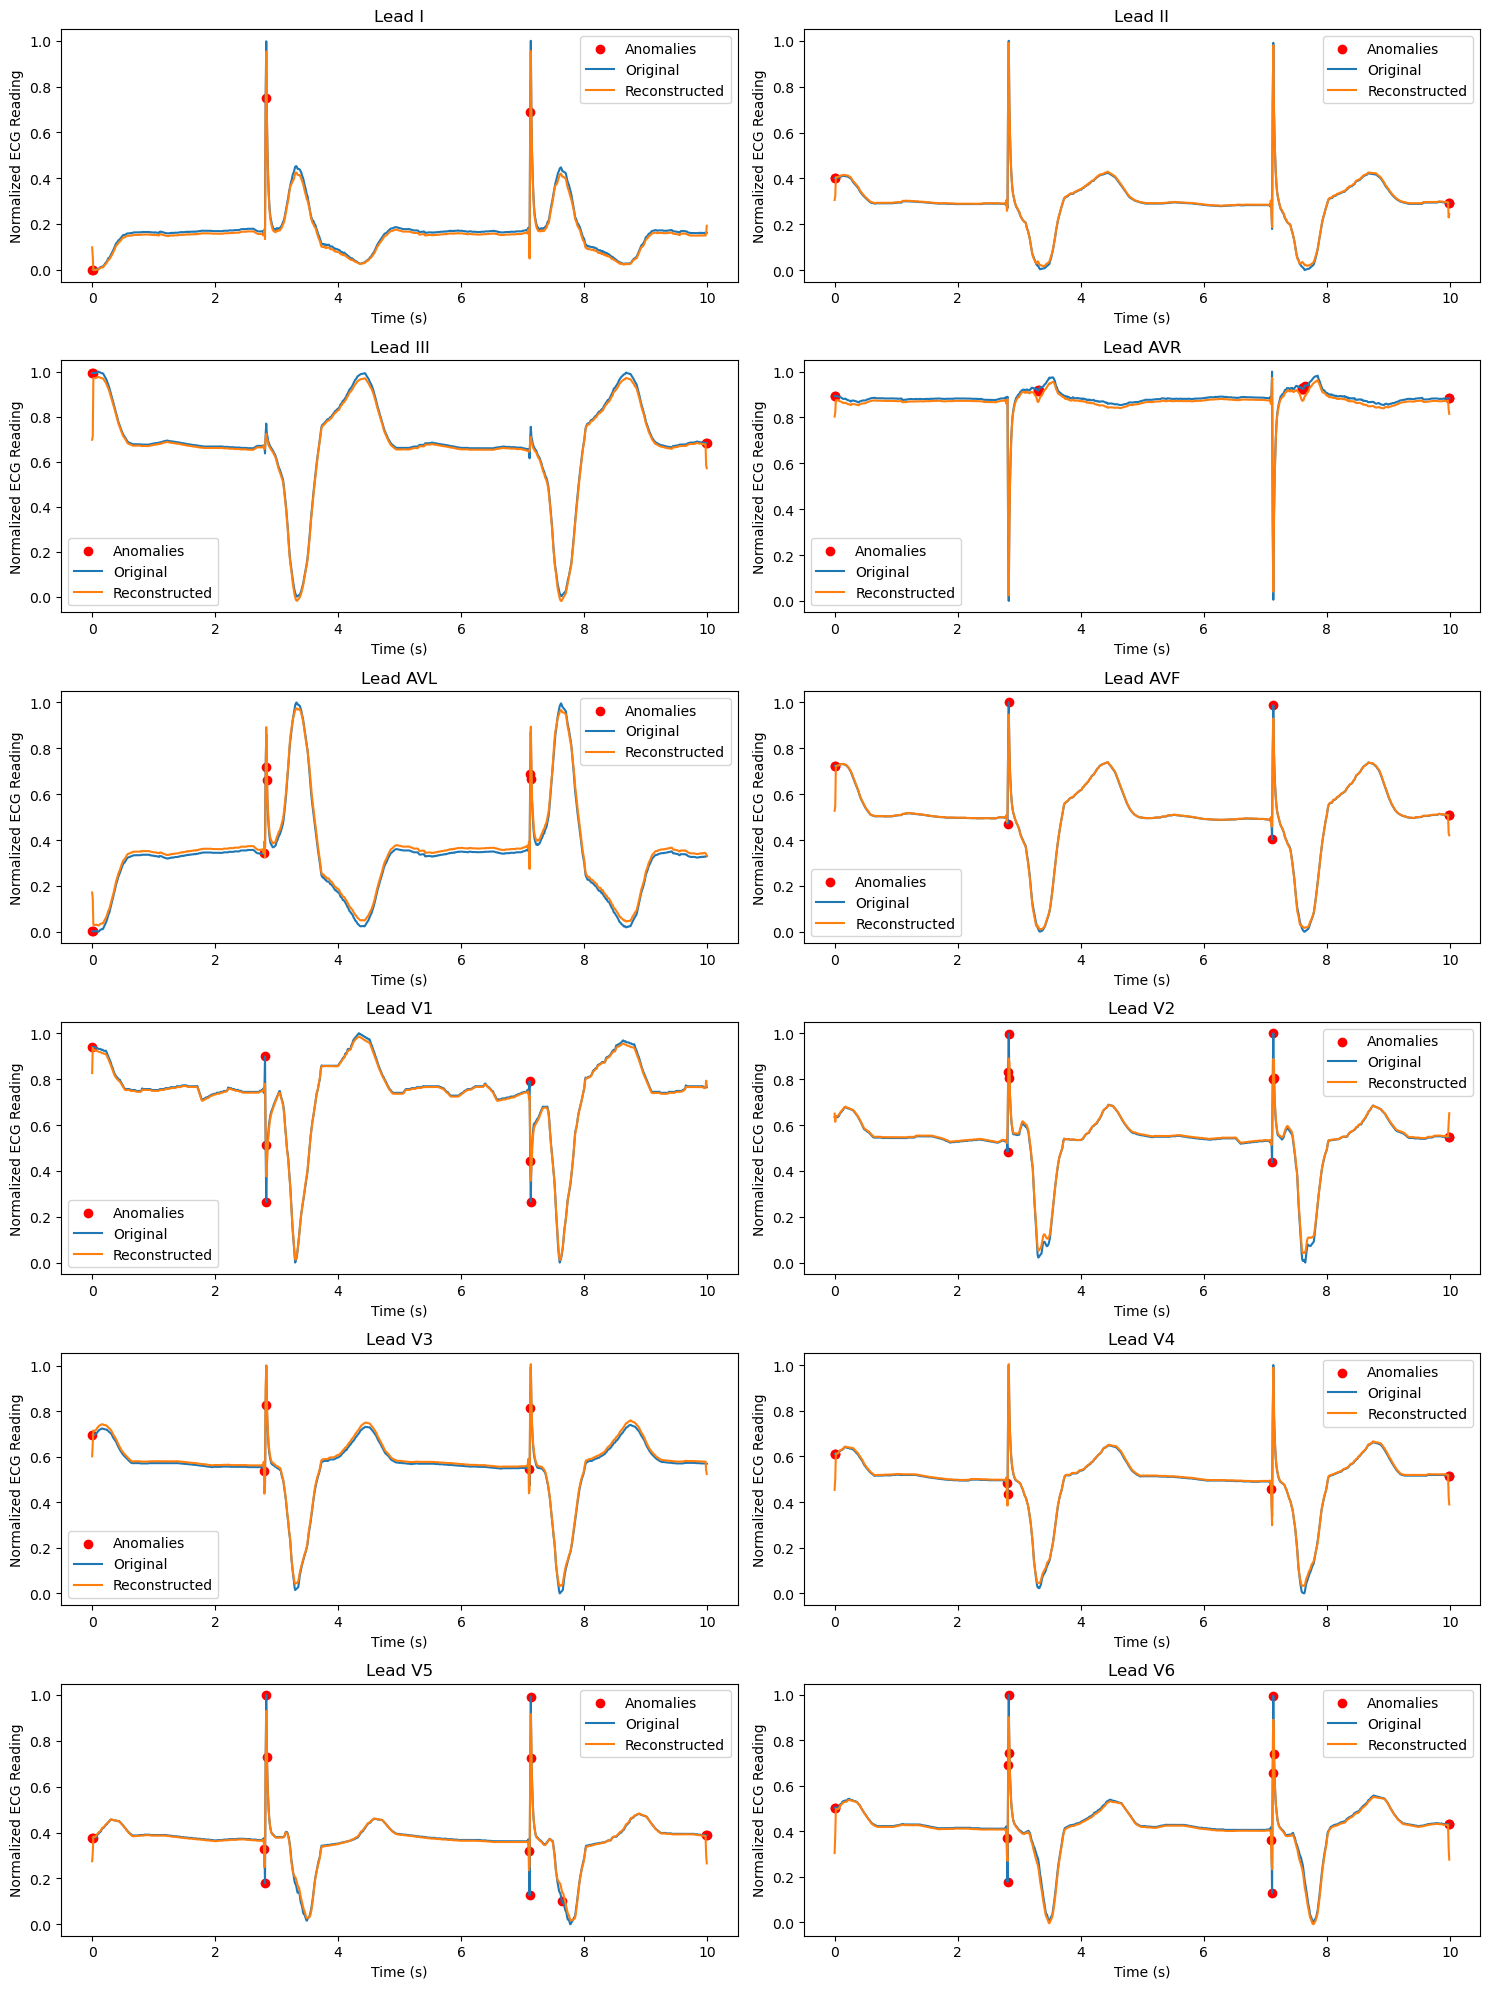

Total number of anomalies: 96


In [47]:
criterion = nn.MSELoss(reduction='none')

single_abnormal_ecg_data = []
single_abnormal_metadata = []

for batch_ecg, batch_metadata in abnormal_test_loader:
    single_abnormal_ecg_data = batch_ecg[0].unsqueeze(0).to(device)  # Move to device
    single_abnormal_metadata = batch_metadata[0].unsqueeze(0).to(device)
    break

noise_factor = 0.001
visualize(combinedModel, single_abnormal_ecg_data, single_abnormal_metadata, criterion, threshold)

# Computational Experiment #1: Transfer Learning #

## Prepare datasets ##

In [14]:
# ECG data
combined_ecg_train = np.concatenate((normal_ecg_train, abnormal_ecg_train), axis=0)
combined_ecg_test = np.concatenate((normal_ecg_test, abnormal_ecg_test), axis=0)
print(f'Combined ECG train set shape: {combined_ecg_train.shape}')
print(f'Combined ECG test set shape: {combined_ecg_test.shape}\n')

# Metadata
combined_metadata_train = pd.concat([normal_metadata_train, abnormal_metadata_train], axis=0)
combined_metadata_test = pd.concat([normal_metadata_test, abnormal_metadata_test], axis=0)
print(f'Combined metadata train set shape: {combined_metadata_train.shape}')
print(f'Combined metadata test set shape: {combined_metadata_test.shape}\n')

# Labels - 1 is normal, 0 is abnormal
train_set_size = normal_ecg_train.shape[0]
test_set_size = normal_ecg_test.shape[0]
labels_train = np.concatenate((np.ones(train_set_size), np.zeros(train_set_size)))
labels_test = np.concatenate((np.ones(test_set_size), np.zeros(test_set_size)))
print(f'Labels train set shape: {labels_train.shape}')
print(f'Labels test set shape: {labels_test.shape}')

Combined ECG train set shape: (14510, 1000, 12)
Combined ECG test set shape: (3628, 1000, 12)

Combined metadata train set shape: (14510, 4)
Combined metadata test set shape: (3628, 4)

Labels train set shape: (14510,)
Labels test set shape: (3628,)


## Normalize and one-hot encode ##

In [15]:
std_combined_ecg_train = normalize_waveform(combined_ecg_train)
std_combined_ecg_test = normalize_waveform(combined_ecg_test)

std_combined_metadata_train, std_combined_metadata_test = normalize_metadata(combined_metadata_train, combined_metadata_test)

## Initialize DataLoaders ##

In [16]:
classifier_ecg_train_set = torch.from_numpy(std_combined_ecg_train).float()
classifier_ecg_test_set = torch.from_numpy(std_combined_ecg_test).float()

classifier_metadata_train_set = torch.from_numpy(std_combined_metadata_train).float()
classifier_metadata_test_set = torch.from_numpy(std_combined_metadata_test).float()

classifier_labels_train_set = torch.from_numpy(labels_train).float()
classifier_labels_test_set = torch.from_numpy(labels_test).float()

In [17]:
batch_size = 32

classifier_train_dataset = TensorDataset(classifier_ecg_train_set,
                                         classifier_metadata_train_set,
                                         classifier_labels_train_set)
classifier_train_loader = DataLoader(classifier_train_dataset, batch_size=batch_size, shuffle=True)

classifier_test_dataset = TensorDataset(classifier_ecg_test_set,
                                         classifier_metadata_test_set,
                                         classifier_labels_test_set)
classifier_test_loader = DataLoader(classifier_test_dataset, batch_size=batch_size, shuffle=False)

## Classifier Model ##

In [18]:
class TransferLearningClassifier(nn.Module):
    def __init__(self, combinedModel):
        super(TransferLearningClassifier, self).__init__()
        
        encoder = combinedModel.cnn_autoencoder.encoder
        lstm = combinedModel.lstm_model
        
        # Freeze the encoder and LSTM weights
        for param in encoder.parameters():
            param.requires_grad = False
        for param in lstm.parameters():
            param.requires_grad = False
            
        self.encoder = encoder
        self.lstm_model = lstm
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(998 * 76, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 1)
        )
        
    def forward(self, ecg_data, metadata, hc):
        ecg_data = ecg_data.permute(0, 2, 1)
        
        cnn_output = self.encoder(ecg_data).permute(0, 2, 1)
        lstm_output, hc_n = self.lstm_model(metadata, hc)
        reshaped_lstm_output = lstm_output.unsqueeze(1).repeat(1, 998, 1)
        
        combined_output = torch.cat((cnn_output, reshaped_lstm_output), dim=-1)
        output = self.fc(combined_output)
        return output, hc_n

## Training ##

In [23]:
tl_classifier = TransferLearningClassifier(combinedModel)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, tl_classifier.parameters()), lr=1e-5)

tl_classifier.to(device)

TransferLearningClassifier(
  (encoder): Sequential(
    (0): Conv1d(12, 64, kernel_size=(3,), stride=(1,))
    (1): ReLU()
  )
  (lstm_model): MetadataLSTM(
    (lstm): LSTM(16, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=12, bias=True)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=75848, out_features=1024, bias=True)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
    (5): Linear(in_features=1024, out_features=256, bias=True)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [24]:
def train_classifier(model, train_loader, criterion, optimizer, nepoch=15):    
    for epoch in range(nepoch):
        num_layers = model.lstm_model.lstm.num_layers
        hidden_size = model.lstm_model.lstm.hidden_size
        h = torch.zeros(num_layers, hidden_size).to(device)
        c = torch.zeros(num_layers, hidden_size).to(device)
        for batch_ecg, batch_metadata, batch_labels in train_loader:
            ecg_data = batch_ecg.to(device).float()
            metadata = batch_metadata.to(device).float()
            labels = batch_labels.to(device).float().unsqueeze(1)
            
            optimizer.zero_grad()
            predictions, (h, c) = model(ecg_data, metadata, (h.detach(), c.detach()))
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()
            
        print(f"Epoch [{epoch+1}/{nepoch}], Loss: {loss.item()}")

In [25]:
train_classifier(tl_classifier, classifier_train_loader, criterion, optimizer)

Epoch [1/15], Loss: 0.5381197929382324
Epoch [2/15], Loss: 0.5587223172187805
Epoch [3/15], Loss: 0.37011271715164185
Epoch [4/15], Loss: 0.3560064435005188
Epoch [5/15], Loss: 0.9498398900032043
Epoch [6/15], Loss: 0.4514404833316803
Epoch [7/15], Loss: 0.24225319921970367
Epoch [8/15], Loss: 0.2887115180492401
Epoch [9/15], Loss: 0.21413098275661469
Epoch [10/15], Loss: 0.27373433113098145
Epoch [11/15], Loss: 0.300945520401001
Epoch [12/15], Loss: 0.48452430963516235
Epoch [13/15], Loss: 0.6370118856430054
Epoch [14/15], Loss: 0.2411794364452362
Epoch [15/15], Loss: 0.1082381010055542


In [28]:
torch.save(tl_classifier.state_dict(), "./models/tl_classifier.pth")

## Testing ##

In [26]:
def test_classifier(model, test_loader):
    num_layers = model.lstm_model.lstm.num_layers
    hidden_size = model.lstm_model.lstm.hidden_size
    h_0 = torch.zeros(num_layers, hidden_size).to(device)
    c_0 = torch.zeros(num_layers, hidden_size).to(device)
    
    total_loss = 0
    accuracies = []
    model.eval()
    with torch.no_grad():
        for batch_ecg, batch_metadata, batch_labels in test_loader:
            ecg_data = batch_ecg.to(device).float()
            metadata = batch_metadata.to(device).float()
            labels = batch_labels.to(device).float().unsqueeze(1)
            
            outputs, _ = model(ecg_data, metadata, (h_0, c_0)) 
            predicted = (outputs > 0.5).float()
            accuracies.append((predicted == labels).float().mean().item())
    
    accuracy = 100 * sum(accuracies) / len(accuracies)
    print(f'Transfer learning classifier test accuracy: {accuracy:.3f}')

In [27]:
test_classifier(tl_classifier, classifier_test_loader)

Transfer learning classifier test accuracy: 73.949


# Computational Experiment #2: TCN Autoencoder #

Model Card for the Hybrid Autoencoder Model Name: Hybrid Autoencoder for ECG and Metadata

Description: This model is designed to learn compressed representations of combined ECG waveform and patient metadata. It utilizes separate pathways for waveform data and metadata, merging them into a dense representation which is then used to reconstruct both types of data.

Model Architecture:

Waveform Pathway: Convolutional layers followed by pooling and flattening. Metadata Pathway: Dense layers. Combined Encoding and Decoding: Dense layers. Intended Use: Intended for anomaly detection in ECG data where additional patient metadata is available and considered relevant.

Data Used for Training: Assumes a dataset comprising ECG waveform data aligned with patient metadata such as age, sex, and device information.

Limitations: The model's effectiveness is highly dependent on the quality and preprocessing of the input data. The architecture needs fine-tuning and validation using real-world data to ensure robustness.

Ethical Considerations: Care should be taken to avoid biases that may arise from imbalanced data across different demographic groups. Privacy concerns should be addressed when handling patient data.

This framework sets up the foundation of your model; further tuning, training, and validation steps are needed to adapt it to specific tasks or datasets.

In [ ]:
num_unique_devices = ptbxl_data['device'].nunique()
print(f"Number of unique devices: {num_unique_devices}")

In [ ]:
from pytorch_tcn import TCN
num_unique_devices = ptbxl_data['device'].nunique()
class TCNAutoencoder(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size, dropout, metadata_dims):
        super(TCNAutoencoder, self).__init__()
        self.encoder = TCN(
            num_inputs=num_inputs,
            num_channels=num_channels,
            kernel_size=kernel_size,
            dropout=dropout,
            causal=True,
        )
        self.age_embedding = nn.Linear(1, metadata_dims[0])  # Age is a single value
        self.sex_embedding = nn.Linear(2, metadata_dims[1])  # Sex is one-hot encoded (2 columns)
        self.device_embedding = nn.Linear(num_unique_devices, metadata_dims[2]) #one hot (11 cols)
        self.validated_embedding = nn.Linear(2, metadata_dims[3]) #one hot (2 cols)
        
        decoder_input_dim = num_channels[-1] + sum(metadata_dims)
        self.decoder = TCN(
            num_inputs=decoder_input_dim,
            num_channels=num_channels[::-1],
            kernel_size=kernel_size,
            dropout=dropout,    
            causal=True,
            output_projection=num_inputs,
        )
        
    def forward(self, x, metadata):
        encoded = self.encoder(x)
        
        age_emb = self.age_embedding(metadata[:, 0].unsqueeze(1))
        sex_emb = self.sex_embedding(metadata[:, 1:3])
        device_emb = self.device_embedding(metadata[:, 3:-2])
        validated_emb = self.validated_embedding(metadata[:, -2:])
        
        metadata_emb = torch.cat([age_emb, sex_emb, device_emb, validated_emb], dim=-1)
        metadata_emb = metadata_emb.unsqueeze(2).expand(-1, -1, encoded.size(2))
        
        concatenated = torch.cat([encoded, metadata_emb], dim=1)
        decoded = self.decoder(concatenated)
        return decoded

In [ ]:
batch_size = 32
num_inputs = 12  # Assuming 12 input channels in the ECG data
num_channels = [32, 64, 128]  # Example number of channels in each residual block of the encoder
kernel_size = 3  # Example kernel size for the TCN layers
dropout = 0.2  # Example dropout rate
metadata_dims = [10, 5, 20, 5]  # Example embedding dimensions for age, sex, and device, and validated

print(std_abnormal_metadata_train.shape)
assert num_unique_devices == std_abnormal_metadata_train.shape[1] - 5, "Number of unique devices should match the number of device columns in metadata"

model = TCNAutoencoder(num_inputs, num_channels, kernel_size, dropout, metadata_dims)

model.to(device)

#train_dataset = TensorDataset(torch.from_numpy(normalized_waveform_train).float(), torch.from_numpy(normalized_metadata_train))
#train_loader = DataLoader(wave, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.001)
num_epochs = 10

In [ ]:
noise_factor = 0.1

for epoch in range(num_epochs):
    for batch_data, batch_metadata in autoencoder_train_loader:
        ecg_data = batch_data.to(device).permute(0, 2, 1).float()
        batch_metadata = batch_metadata.to(device).float()
        
        noise = torch.randn_like(ecg_data) * noise_factor
        noisy_ecg_data = ecg_data + noise
        
        optimizer.zero_grad()
        reconstructed_data = model(noisy_ecg_data, batch_metadata)
        loss = criterion(reconstructed_data, ecg_data)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

In [ ]:
torch.save(model.state_dict(), "./models/tcn.pth")
print(f"Model saved")

In [ ]:
#reinit model
batch_size = 32
num_inputs = 12  # Assuming 12 input channels in the ECG data
num_channels = [32, 64, 128]  # Example number of channels in each residual block of the encoder
kernel_size = 3  # Example kernel size for the TCN layers
dropout = 0.2  # Example dropout rate
metadata_dims = [10, 5, 20, 5]  # Example embedding dimensions for age, sex, and device, and validated

model = TCNAutoencoder(num_inputs, num_channels, kernel_size, dropout, metadata_dims)
model.load_state_dict(torch.load("./models/tcn.pth"))
model.to(device)

criterion = nn.MSELoss()

def test(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_data, batch_metadata in test_loader:
            ecg_data = batch_data.to(device).permute(0, 2, 1).float()
            batch_metadata = batch_metadata.to(device).float()
            reconstructed_data = model(ecg_data, batch_metadata)
            loss = criterion(reconstructed_data, ecg_data)
            test_loss += loss.item()
    test_loss /= len(test_loader)
    print(f"Test Loss: {test_loss:.4f}")

In [ ]:
test(model, normal_test_loader, criterion)

In [ ]:
def visualize_predictions_tcn(model, ecg_input, metadata_input):
    lead_vals = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    time = np.arange(0, ecg_input.shape[1]) / 100  # Assuming a sampling rate of 100 Hz

    model.eval()
    with torch.no_grad():
        ecg_input = ecg_input.permute(0, 2, 1).float().to(device)  # Reshape input to (batch_size, num_channels, seq_length)
        metadata_input = metadata_input.float().to(device)
        
        # Add noise to the input data
        noise = torch.randn_like(ecg_input) * noise_factor
        noisy_ecg_input = ecg_input + noise
        
        prediction = model(noisy_ecg_input, metadata_input)
        prediction = prediction.permute(0, 2, 1)  # Reshape output to (batch_size, seq_length, num_channels)
        
        fig, axs = plt.subplots(6, 2, figsize=(15, 20))
        for i in range(6):
            for j in range(2):
                lead_idx = i * 2 + j
                lead_val = lead_vals[lead_idx]
                original_ecg = ecg_input[0, lead_idx, :].cpu().numpy()
                noisy_ecg = noisy_ecg_input[0, lead_idx, :].cpu().numpy()
                reconstructed_ecg = prediction[0, :, lead_idx].cpu().numpy()
                axs[i, j].plot(time, original_ecg, label='Original')
                axs[i, j].plot(time, noisy_ecg, label='Noisy Input')
                axs[i, j].plot(time, reconstructed_ecg, label='Reconstructed')
                axs[i, j].set_xlabel('Time (s)')
                axs[i, j].set_ylabel('Normalized ECG Reading')
                axs[i, j].set_title(f'Lead {lead_val}')
                axs[i, j].legend()
        
        plt.tight_layout()
        plt.show()

In [ ]:
ecg_input = next(iter(autoencoder_train_loader))[0]
metadata_input = next(iter(autoencoder_train_loader))[1]
visualize_predictions_tcn(model, ecg_input, metadata_input, noise_factor)